## Name: Rohail Ahmad
## Reg No: B22F1198AI014

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 196MB/s] 


Epoch 1/10: Train Acc: 0.9357, Val Acc: 0.9667
Epoch 2/10: Train Acc: 0.9731, Val Acc: 0.9820
Epoch 3/10: Train Acc: 0.9782, Val Acc: 0.9807
Epoch 4/10: Train Acc: 0.9820, Val Acc: 0.9867
Epoch 5/10: Train Acc: 0.9888, Val Acc: 0.9867
Epoch 6/10: Train Acc: 0.9882, Val Acc: 0.9933
Epoch 7/10: Train Acc: 0.9907, Val Acc: 0.9960
Epoch 8/10: Train Acc: 0.9939, Val Acc: 0.9873
Epoch 9/10: Train Acc: 0.9926, Val Acc: 0.9987
Epoch 10/10: Train Acc: 0.9946, Val Acc: 0.9980


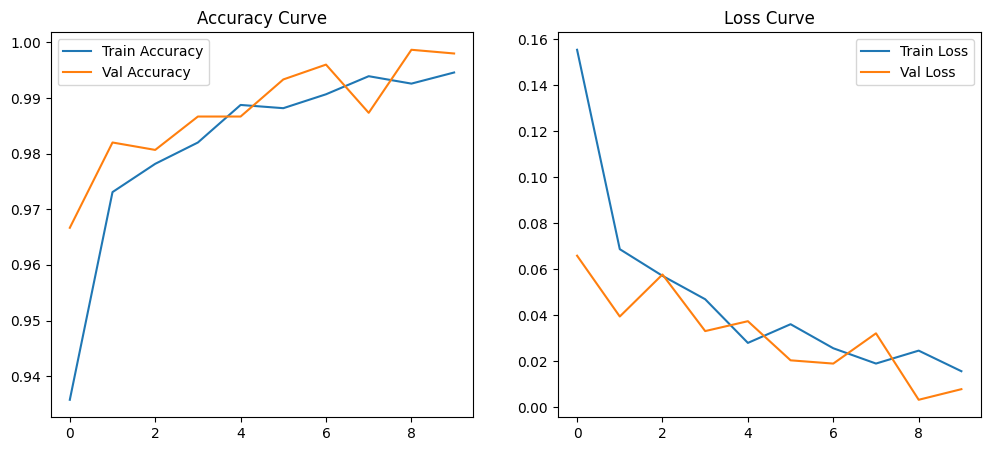

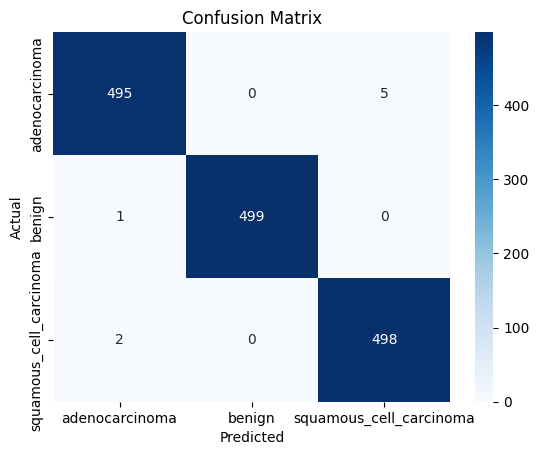


Classification Report:
                          precision    recall  f1-score   support

         adenocarcinoma       0.99      0.99      0.99       500
                 benign       1.00      1.00      1.00       500
squamous_cell_carcinoma       0.99      1.00      0.99       500

               accuracy                           0.99      1500
              macro avg       0.99      0.99      0.99      1500
           weighted avg       0.99      0.99      0.99      1500



In [1]:
import os
import shutil
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

data_dir = "/kaggle/input/lung-cancer-histopathological-images"
split_dir = "/kaggle/working/split_dataset"

# Create directories for train, val, test
train_dir = os.path.join(split_dir, "train")
val_dir = os.path.join(split_dir, "val")
test_dir = os.path.join(split_dir, "test")

for split in [train_dir, val_dir, test_dir]:
    os.makedirs(split, exist_ok=True)
    for category in os.listdir(data_dir):
        os.makedirs(os.path.join(split, category), exist_ok=True)

# Split dataset (80% train, 10% val, 10% test)
for category in os.listdir(data_dir):
    images = os.listdir(os.path.join(data_dir, category))
    random.shuffle(images)
    
    train_split = int(0.8 * len(images))
    val_split = int(0.9 * len(images))
    
    for i, img in enumerate(images):
        src_path = os.path.join(data_dir, category, img)
        if i < train_split:
            dst_path = os.path.join(train_dir, category, img)
        elif i < val_split:
            dst_path = os.path.join(val_dir, category, img)
        else:
            dst_path = os.path.join(test_dir, category, img)
        shutil.copy(src_path, dst_path)

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
data_loaders = {}
for split in ["train", "val", "test"]:
    dataset = datasets.ImageFolder(os.path.join(split_dir, split), transform=transform)
    data_loaders[split] = DataLoader(dataset, batch_size=32, shuffle=(split == "train"))

# Load AlexNet model
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(4096, 3)  # Modify output layer for 3 classes
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train_model(model, criterion, optimizer, num_epochs=10):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.train()
    train_acc, val_acc, train_loss, val_loss = [], [], [], []
    
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in data_loaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_loss.append(running_loss / len(data_loaders['train']))
        train_acc.append(correct / total)
        
        # Validation
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in data_loaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        val_loss.append(val_running_loss / len(data_loaders['val']))
        val_acc.append(val_correct / val_total)
        model.train()
        print(f"Epoch {epoch+1}/{num_epochs}: Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")
    return train_acc, val_acc, train_loss, val_loss

train_acc, val_acc, train_loss, val_loss = train_model(model, criterion, optimizer, num_epochs=10)

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

# Evaluation
model.eval()
true_labels, pred_labels = [], []
with torch.no_grad():
    for inputs, labels in data_loaders['test']:
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data_loaders['test'].dataset.classes, yticklabels=data_loaders['test'].dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print("\nClassification Report:\n", classification_report(true_labels, pred_labels, target_names=data_loaders['test'].dataset.classes))

# Save model
torch.save(model.state_dict(), "alexnet_lung_cancer.pth")

In [2]:
import os
import cv2
import numpy as np

# Input dataset path (adjust to your actual dataset name)
input_base_path = '/kaggle/input/lung-cancer-histopathological-images'  # Replace this

# Clean new output directories
output_base_path = '/kaggle/working/annotated_v2'
output_img_path = os.path.join(output_base_path, 'images')
output_label_path = os.path.join(output_base_path, 'labels')

os.makedirs(output_img_path, exist_ok=True)
os.makedirs(output_label_path, exist_ok=True)

# Class mapping
class_names = ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']
class_to_index = {name: i for i, name in enumerate(class_names)}

# Process image and write annotation
def process_image(img_path, class_index, file_name):
    img = cv2.imread(img_path)
    if img is None:
        return False

    h_img, w_img = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold + Morph
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((5, 5), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest)

        if w > 20 and h > 20:
            # Normalize
            x_center = (x + w / 2) / w_img
            y_center = (y + h / 2) / h_img
            w_norm = w / w_img
            h_norm = h / h_img

            # Save label
            label_name = os.path.splitext(file_name)[0] + '.txt'
            label_path = os.path.join(output_label_path, label_name)
            with open(label_path, 'w') as f:
                f.write(f"{class_index} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")

            # Save image
            cv2.imwrite(os.path.join(output_img_path, file_name), img)

            return True

    return False

# Main loop
for class_name in class_names:
    class_index = class_to_index[class_name]
    folder_path = os.path.join(input_base_path, class_name)

    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            full_path = os.path.join(folder_path, file_name)
            success = process_image(full_path, class_index, file_name)
            if not success:
                print(f"⚠️ No bbox for {file_name} in {class_name}")

print(f"✅ Finished. Check: {output_base_path}")


✅ Finished. Check: /kaggle/working/annotated_v2


In [3]:
!pip install -q ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.5/974.5 kB 24.9 MB/s eta 0:00:0000:01


In [4]:
!pip install ultralytics

In [5]:
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
model = YOLO('yolov8n.pt')  # 'n' refers to the nano version; you can choose 's', 'm', 'l', or 'x' for larger models


100%|██████████| 6.25M/6.25M [00:00<00:00, 114MB/s]


In [10]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
base_path = '/kaggle/working/annotated_v2'
output_path = '/kaggle/working/yolo9_data'

images = [f for f in os.listdir(os.path.join(base_path, 'images')) if f.endswith(('.jpg', '.png', '.jpeg'))]
train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

# Folders
for split in ['train', 'val']:
    for sub in ['images', 'labels']:
        os.makedirs(os.path.join(output_path, split, sub), exist_ok=True)

# Move images and labels
def copy_data(file_list, split):
    for file in file_list:
        label_file = file.rsplit('.', 1)[0] + '.txt'
        shutil.copy(os.path.join(base_path, 'images', file), os.path.join(output_path, split, 'images', file))
        shutil.copy(os.path.join(base_path, 'labels', label_file), os.path.join(output_path, split, 'labels', label_file))

copy_data(train_imgs, 'train')
copy_data(val_imgs, 'val')

In [11]:
dataset_yaml = """
path: /kaggle/working/yolo9_data
train: train/images
val: val/images

names:
  0: adenocarcinoma
  1: benign
  2: squamous_cell_carcinoma
"""

with open('/kaggle/working/yolo9_data.yaml', 'w') as f:
    f.write(dataset_yaml)


In [13]:
from ultralytics import YOLO

# Load YOLOv9 (you can also try 'yolov9c.pt' or 'yolov9e.pt' for larger models)
model = YOLO('yolov8n.pt')  # 'n' = nano model (fastest/smallest)

# Train
model.train(
    data='/kaggle/working/yolo9_data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    name='lung-cancer-yolov9',
    project='/kaggle/working/yolov9_runs'
)

Ultralytics 8.3.107 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/yolo9_data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/kaggle/working/yolov9_runs, name=lung-cancer-yolov9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labe

100%|██████████| 755k/755k [00:00<00:00, 25.0MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 101MB/s]
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:260: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:269: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context:

AMP: checks passed ✅


train: Scanning /kaggle/working/yolo9_data/train/labels... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:03<00:00, 1205.20it/s]


train: New cache created: /kaggle/working/yolo9_data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/yolo9_data/val/labels... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:01<00:00, 670.73it/s]

val: New cache created: /kaggle/working/yolo9_data/val/labels.cache


Plotting labels to /kaggle/working/yolov9_runs/lung-cancer-yolov9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/yolov9_runs/lung-cancer-yolov9
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       1/50      3.05G     0.2082     0.8762     0.9842         45        640: 100%|██████████| 250/250 [00:48<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.995      0.993

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       2/50      3.31G     0.1418     0.3479     0.9256         45        640: 100%|██████████| 250/250 [00:46<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       3/50      3.31G     0.1352     0.2608      0.922         58        640: 100%|██████████| 250/250 [00:46<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.996      0.998      0.995      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       4/50      3.31G      0.124     0.2169     0.9177         51        640: 100%|██████████| 250/250 [00:45<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.994      0.998      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       5/50      3.31G     0.1164     0.1959     0.9166         36        640: 100%|██████████| 250/250 [00:45<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       6/50      3.31G     0.1049     0.1772     0.9163         42        640: 100%|██████████| 250/250 [00:45<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       7/50      3.31G    0.09603     0.1623     0.9125         51        640: 100%|██████████| 250/250 [00:45<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       8/50      3.31G    0.09425     0.1614     0.9105         45        640: 100%|██████████| 250/250 [00:46<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.997      0.998      0.994      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       9/50      3.31G    0.08634      0.149     0.9029         49        640: 100%|██████████| 250/250 [00:45<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      10/50      3.31G    0.08469      0.146     0.9069         42        640: 100%|██████████| 250/250 [00:45<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      11/50      3.31G    0.08199     0.1474     0.9068         48        640: 100%|██████████| 250/250 [00:45<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      12/50      3.31G     0.0789     0.1377     0.9024         51        640: 100%|██████████| 250/250 [00:45<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.993      0.997      0.994      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      13/50      3.31G    0.07663     0.1345     0.9045         47        640: 100%|██████████| 250/250 [00:45<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      14/50      3.31G    0.07206     0.1285     0.9022         40        640: 100%|██████████| 250/250 [00:45<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.995      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      15/50      3.31G    0.06826     0.1221     0.9024         48        640: 100%|██████████| 250/250 [00:45<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.993      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      16/50      3.31G    0.06908     0.1268     0.9029         47        640: 100%|██████████| 250/250 [00:45<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.996      0.998      0.994      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      17/50      3.31G    0.06751     0.1198     0.9017         51        640: 100%|██████████| 250/250 [00:45<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.996      0.997      0.993       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      18/50      3.31G    0.06148     0.1121     0.8992         47        640: 100%|██████████| 250/250 [00:45<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      19/50      3.31G    0.06216     0.1149     0.9004         51        640: 100%|██████████| 250/250 [00:45<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      20/50      3.31G    0.06225     0.1111     0.9091         53        640: 100%|██████████| 250/250 [00:45<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.997      0.998      0.993      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      21/50      3.31G    0.05956     0.1118     0.9043         42        640: 100%|██████████| 250/250 [00:45<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.997      0.998      0.993      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      22/50      3.31G    0.05975     0.1156     0.8989         49        640: 100%|██████████| 250/250 [00:45<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      23/50      3.31G    0.05837     0.1158     0.9008         54        640: 100%|██████████| 250/250 [00:45<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      24/50      3.31G      0.056     0.1079     0.9008         55        640: 100%|██████████| 250/250 [00:45<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      25/50      3.31G        inf     0.1032      0.896         55        640: 100%|██████████| 250/250 [00:45<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.993      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      26/50      3.31G    0.05113     0.1016     0.8961         57        640: 100%|██████████| 250/250 [00:45<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      27/50      3.31G    0.05353    0.09742      0.901         50        640: 100%|██████████| 250/250 [00:45<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.993      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      28/50      3.31G    0.04971    0.09916     0.8958         52        640: 100%|██████████| 250/250 [00:45<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.993      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      29/50      3.31G    0.05104    0.09661     0.8998         47        640: 100%|██████████| 250/250 [00:45<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.993      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      30/50      3.31G    0.04754    0.09685     0.8962         53        640: 100%|██████████| 250/250 [00:45<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      31/50      3.31G    0.04356    0.09173     0.8977         50        640: 100%|██████████| 250/250 [00:46<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      32/50      3.31G    0.04578    0.08716     0.8986         53        640: 100%|██████████| 250/250 [00:45<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      33/50      3.31G    0.04471    0.08742      0.899         45        640: 100%|██████████| 250/250 [00:45<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.993      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      34/50      3.31G    0.04586    0.08942     0.9017         51        640: 100%|██████████| 250/250 [00:45<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      35/50      3.31G    0.04271    0.08695      0.897         56        640: 100%|██████████| 250/250 [00:45<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.993      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      36/50      3.31G    0.04102     0.0846     0.8969         54        640: 100%|██████████| 250/250 [00:46<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      37/50      3.31G     0.0411    0.08188     0.8982         44        640: 100%|██████████| 250/250 [00:45<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.993      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      38/50      3.31G    0.03934    0.07931     0.9005         53        640: 100%|██████████| 250/250 [00:46<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      39/50      3.31G     0.0388    0.08153      0.897         44        640: 100%|██████████| 250/250 [00:45<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      40/50      3.31G    0.03739    0.07983     0.9011         49        640: 100%|██████████| 250/250 [00:45<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.993      0.992


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      41/50      3.31G    0.03916     0.1224     0.9196         16        640: 100%|██████████| 250/250 [00:46<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.993      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      42/50      3.31G    0.03422    0.04346     0.9176         16        640: 100%|██████████| 250/250 [00:45<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      43/50      3.31G    0.03001    0.04004     0.9139         16        640: 100%|██████████| 250/250 [00:45<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      44/50      3.31G    0.02873    0.03667      0.912         16        640: 100%|██████████| 250/250 [00:45<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      45/50      3.31G    0.02613    0.03574     0.9094         16        640: 100%|██████████| 250/250 [00:45<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.993      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      46/50      3.31G    0.02541    0.03236     0.9166         16        640: 100%|██████████| 250/250 [00:45<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      47/50      3.31G    0.02334     0.0313     0.9181         16        640: 100%|██████████| 250/250 [00:45<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.993      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      48/50      3.31G    0.02338    0.03219     0.9142         16        640: 100%|██████████| 250/250 [00:45<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      49/50      3.31G    0.02004    0.02763     0.9132         16        640: 100%|██████████| 250/250 [00:45<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.994      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      50/50      3.31G    0.01889    0.02561     0.9137         16        640: 100%|██████████| 250/250 [00:45<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R   

                   all       1000       1000      0.998      0.998      0.993      0.992



50 epochs completed in 0.720 hours.
Optimizer stripped from /kaggle/working/yolov9_runs/lung-cancer-yolov9/weights/last.pt, 6.2MB
Optimizer stripped from /kaggle/working/yolov9_runs/lung-cancer-yolov9/weights/best.pt, 6.2MB

Validating /kaggle/working/yolov9_runs/lung-cancer-yolov9/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:260: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:269: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operati

                   all       1000       1000      0.998      0.998      0.995      0.994
squamous_cell_carcinoma       1000       1000      0.998      0.998      0.995      0.994


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /kaggle/working/yolov9_runs/lung-cancer-yolov9


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ea357434be0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

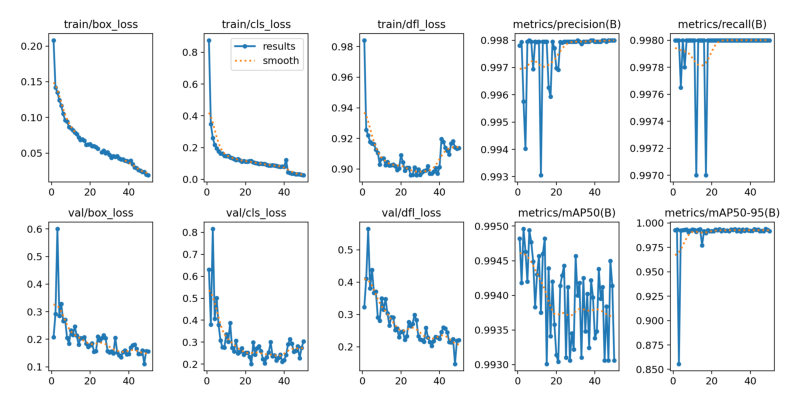

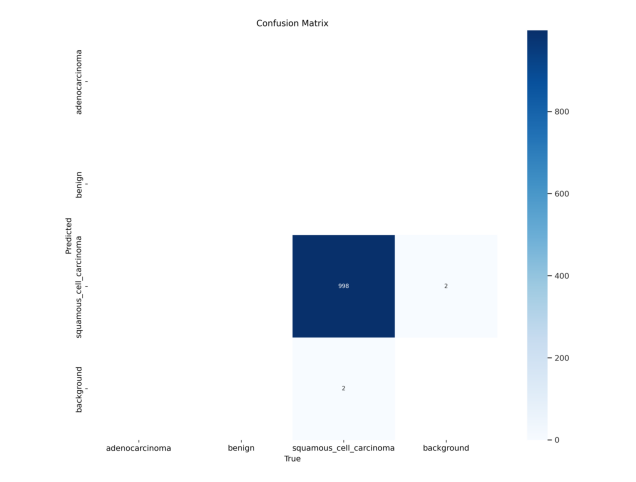

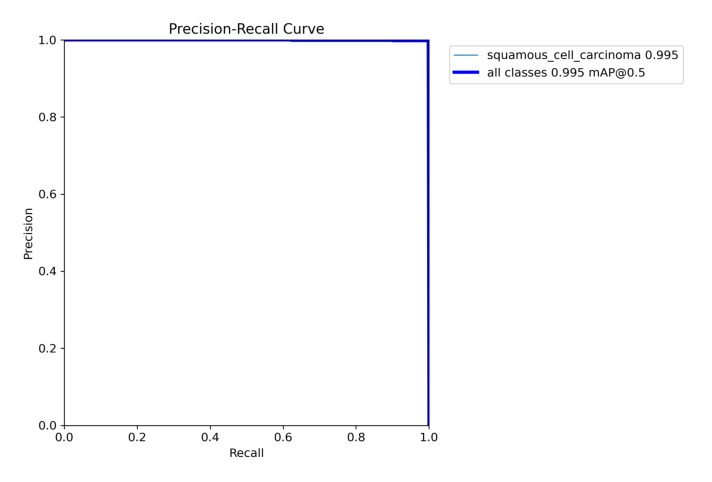

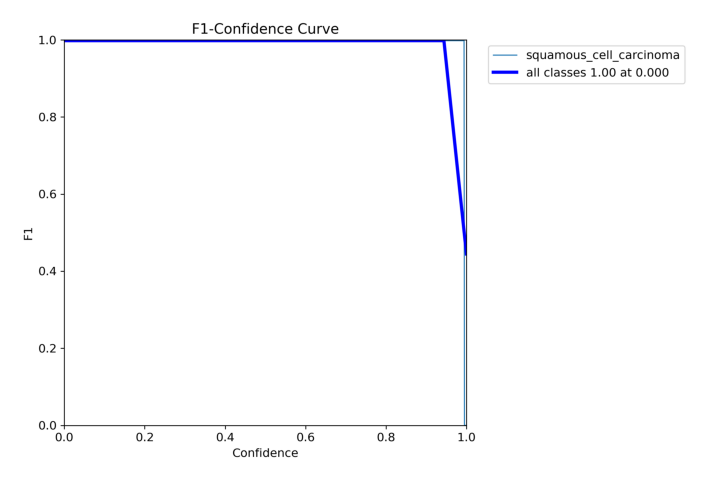

In [14]:
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image, display

# Helper to load and show image
def show_plot(path):
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

# Show results
show_plot('yolov9_runs/lung-cancer-yolov9/results.png')
show_plot('yolov9_runs/lung-cancer-yolov9/confusion_matrix.png')
show_plot('yolov9_runs/lung-cancer-yolov9/PR_curve.png')
show_plot('yolov9_runs/lung-cancer-yolov9/F1_curve.png')             